# Creating CellChat Objects

In [2]:
library(CellChat, lib.loc="../R/4.0/library")
library(Seurat)
library(patchwork)
library(dplyr)
library(ggplot2)
library(pheatmap, warn.conflicts = FALSE)
library(ggpubr)
library(data.table)
library(igraph)
library(RColorBrewer)

Warning message:
“package ‘CellChat’ was built under R version 4.3.0”
Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: igraph


Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Loading required package: ggplot2

The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Sugges

In [2]:
# Load and merge Seurat objects
Endothelial <- readRDS( "../processed_data/Obj6_ACC_New_nLung_nLiver_Endothelial_FastMNN.rds")
Fibroblast <- readRDS( "../processed_data/Obj6_ACC_New_nLung_nLiver_Fibroblast_FastMNN.rds")
Myeloid <- readRDS( "../processed_data/Obj6_ACC_New_nLung_nLiver_Myeloid_FastMNN.rds")
Lymphoid <- readRDS( "../processed_data/Obj6_New_ACC_nLung_nLiver_Lymphoid_FastMNN.rds")
Malignant <- readRDS('../processed_data/Obj6_ACC_NMF_Clustered.rds')
object <- merge(Endothelial, c(Fibroblast, Myeloid, Lymphoid, Malignant)) ## merge all compartments

# change metadata sample_type labeling
object <- AddMetaData(object,
                     object@meta.data %>% mutate(
                     sample_type = ifelse(sample_type == "ACC_Met", "MME", sample_type),
                     sample_type = ifelse(sample_type == "Adj_Tissue", "CCME", sample_type),
                     sample_type = ifelse(sample_type == "Healthy", "HME", sample_type)))

# subset for Lung only and by sample type
object <- subset(object, subset = site == 'Lung')
HME <- subset(object, subset = sample_type == 'HME')
CCME <- subset(object, subset = sample_type == 'CCME')
MME <- subset(object, subset = sample_type == 'MME')

In [5]:
# Create HME Cellchat Object
data.input <- HME[["RNA"]]@counts
data.input <- normalizeData(data.input)

meta <- HME@meta.data[c("patient_code", "sample_type", "cluster", "site")]
meta$condition <- meta$sample_type 
meta$sample_type <- NULL  
meta$labels <- meta$cluster 
meta$cluster <- NULL 


cellchat <- createCellChat(object = data.input, meta = meta, group.by = "labels")
CellChatDB <- CellChatDB.human 
cellchat@DB <- CellChatDB
cellchat <- subsetData(cellchat) 
cellchat <- identifyOverExpressedGenes(cellchat)
cellchat <- identifyOverExpressedInteractions(cellchat)
cellchat <- computeCommunProb(cellchat, population.size = F, type =  "truncatedMean", trim = 0.1)
cellchat <- filterCommunication(cellchat, min.cells = 100)
cellchat <- computeCommunProbPathway(cellchat)
cellchat <- aggregateNet(cellchat)

cellchat_HME <- cellchat

# Create CCME Cellchat Object
data.input <- CCME[["RNA"]]@counts
data.input <- normalizeData(data.input)

meta <- CCME@meta.data[c("patient_code", "sample_type", "cluster", "site")]
meta$condition <- meta$sample_type 
meta$sample_type <- NULL  
meta$labels <- meta$cluster 
meta$cluster <- NULL 


cellchat <- createCellChat(object = data.input, meta = meta, group.by = "labels")
CellChatDB <- CellChatDB.human 
cellchat@DB <- CellChatDB
cellchat <- subsetData(cellchat) 
cellchat <- identifyOverExpressedGenes(cellchat)
cellchat <- identifyOverExpressedInteractions(cellchat)
cellchat <- computeCommunProb(cellchat, population.size = F, type =  "truncatedMean", trim = 0.1)
cellchat <- filterCommunication(cellchat, min.cells = 100)
cellchat <- computeCommunProbPathway(cellchat)
cellchat <- aggregateNet(cellchat)

cellchat_CCME <- cellchat

# Create MME Cellchat Object
data.input <- MME[["RNA"]]@counts
data.input <- normalizeData(data.input)

meta <- MME@meta.data[c("patient_code", "sample_type", "cluster", "site")]
meta$condition <- meta$sample_type 
meta$sample_type <- NULL  
meta$labels <- meta$cluster 
meta$cluster <- NULL 


cellchat <- createCellChat(object = data.input, meta = meta, group.by = "labels")
CellChatDB <- CellChatDB.human 
cellchat@DB <- CellChatDB
cellchat <- subsetData(cellchat) 
cellchat <- identifyOverExpressedGenes(cellchat)
cellchat <- identifyOverExpressedInteractions(cellchat)
cellchat <- computeCommunProb(cellchat, population.size = F, type =  "truncatedMean", trim = 0.1)
cellchat <- filterCommunication(cellchat, min.cells = 100)
cellchat <- computeCommunProbPathway(cellchat)
cellchat <- aggregateNet(cellchat)

cellchat_MME <- cellchat

# CellChat Analysis

In [4]:
## create combined cellchat object from HME, CCME, and MME
object.list_H_A_M <- list(HME = cellchat_HME, CCME = cellchat_CCME, MME = cellchat_MME)
cellchat <- mergeCellChat(object.list_H_A_M, add.names = names(object.list_H_A_M))

Merge the following slots: 'data.signaling','images','net', 'netP','meta', 'idents', 'var.features' , 'DB', and 'LR'.



## CellChat: Differential signaling CCME vs HME (WordCloud)

In [6]:
## create combined cellchat object from HME, CCME
object.list_H_A <- list(HME = cellchat_HME, CCME = cellchat_CCME)
cellchat <- mergeCellChat(object.list_H_A, add.names = names(object.list_H_A))

Merge the following slots: 'data.signaling','images','net', 'netP','meta', 'idents', 'var.features' , 'DB', and 'LR'.



Use the joint cell labels from the merged CellChat object



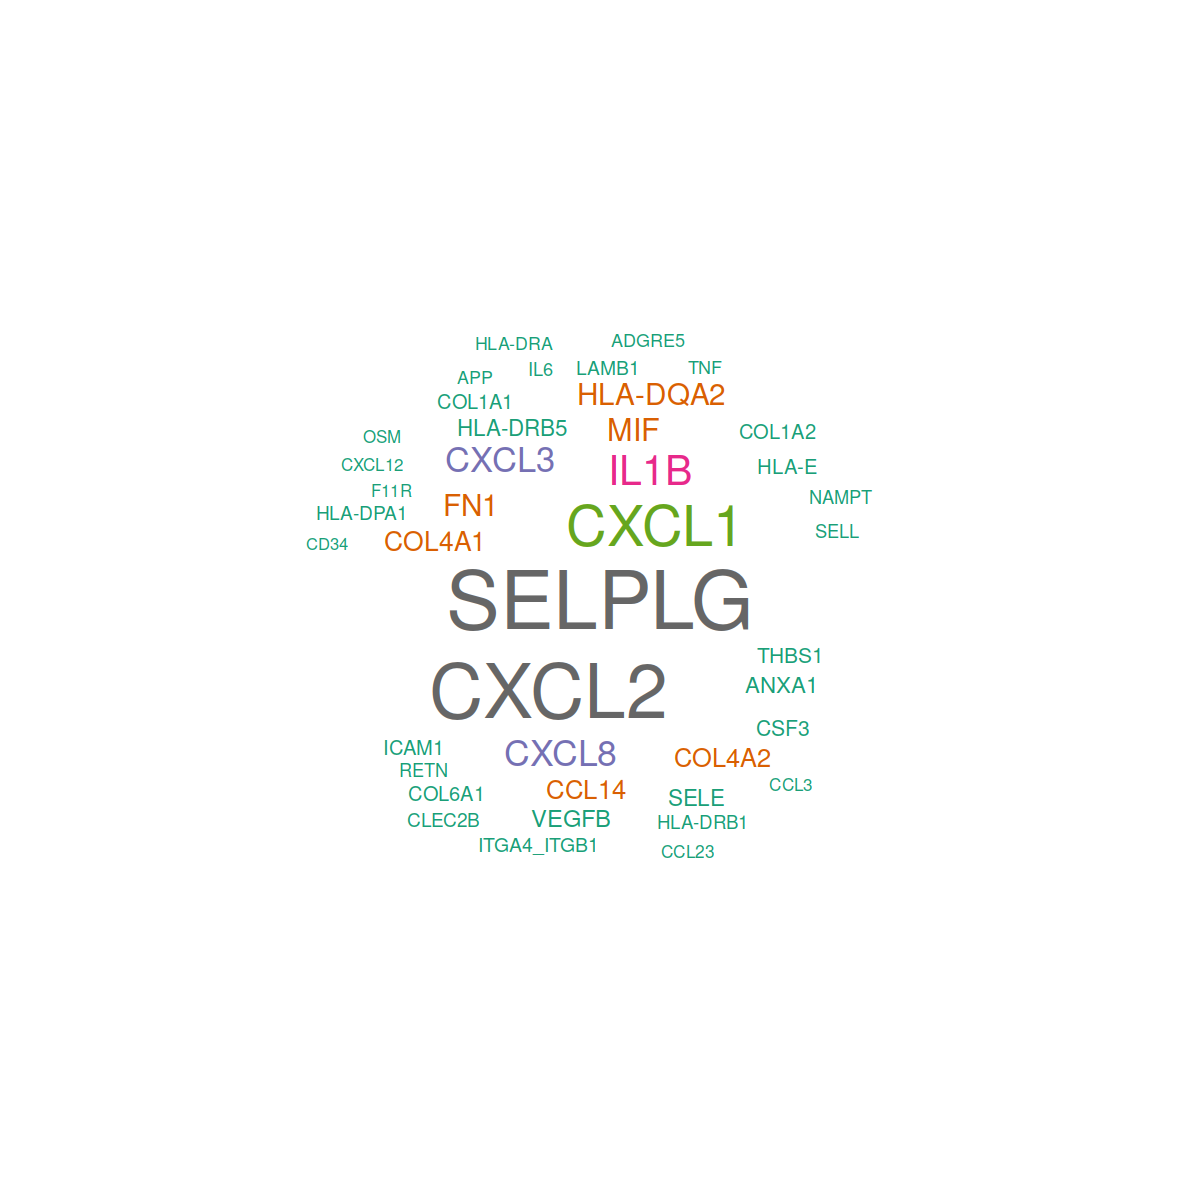

In [7]:
## Genes overexpressed (logFC 0.3, p < 0.05, in at least 10 percent of cells within cluster), all upregulated signaling pathways

# define a positive dataset, i.e., the dataset with positive fold change against the other dataset
pos.dataset = "CCME"
# define a char name used for storing the results of differential expression analysis
features.name = pos.dataset
# perform differential expression analysis
cellchat <- identifyOverExpressedGenes(cellchat, group.dataset = "datasets", pos.dataset = pos.dataset, features.name = features.name, only.pos = TRUE, thresh.pc = 0.1, thresh.fc = 0.3, thresh.p = 0.05)
# map the results of differential expression analysis onto the inferred cell-cell communications to easily manage/subset the ligand-receptor pairs of interest
net <- netMappingDEG(cellchat, features.name = features.name)
# extract the ligand-receptor pairs with upregulated signaling in CCME
net.up <- subsetCommunication(cellchat, net = net, datasets = "CCME") 
# extract the ligand-receptor pairs with upregulated ligands and upregulated recetptors in HME, i.e.,downregulated in CCME
# net.down <- subsetCommunication(cellchat, net = net, datasets = "HME",ligand.logFC = -0.3, receptor.logFC = -0.3)


net.up <- na.omit(net.up)
options(repr.plot.height = 10, repr.plot.width = 10)
computeEnrichmentScore(net.up, species = 'human', measure = c("signaling"))
options(repr.plot.height = 7, repr.plot.width = 7)


## CellChat: Differential signaling MME vs HME (WordCloud)

Use the joint cell labels from the merged CellChat object



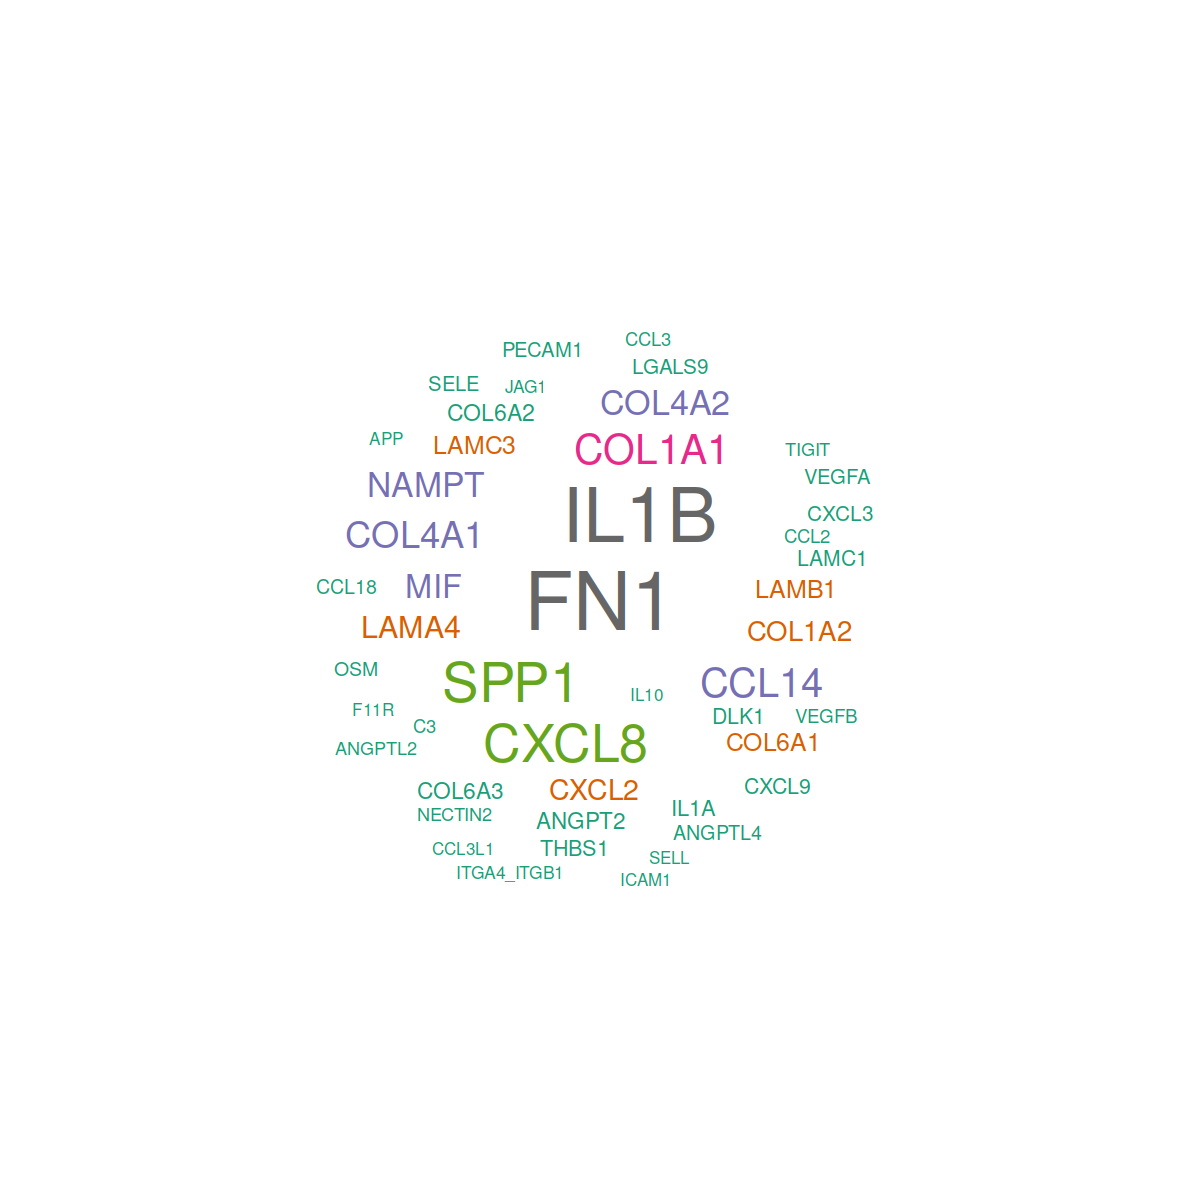

In [20]:
## create combined cellchat object from HME, CCME, and MME
object.list_H_M <- list(HME = cellchat_HME, MME = cellchat_MME)
cellchat <- mergeCellChat(object.list_H_M, add.names = names(object.list_H_M))
# define a positive dataset, i.e., the dataset with positive fold change against the other dataset
pos.dataset = "MME"
# define a char name used for storing the results of differential expression analysis
features.name = pos.dataset
# perform differential expression analysis
cellchat <- identifyOverExpressedGenes(cellchat, group.dataset = "datasets", pos.dataset = pos.dataset, features.name = features.name, only.pos = TRUE, thresh.pc = 0.1, thresh.fc = 0.3, thresh.p = 0.05)
# map the results of differential expression analysis onto the inferred cell-cell communications to easily manage/subset the ligand-receptor pairs of interest
net <- netMappingDEG(cellchat, features.name = features.name)
# extract the ligand-receptor pairs with upregulated signaling in MME
net.up <- subsetCommunication(cellchat, net = net, datasets = "MME") 
# extract the ligand-receptor pairs with upregulated ligands and upregulated recetptors in HME, i.e.,downregulated in MME
# net.down <- subsetCommunication(cellchat, net = net, datasets = "HME",ligand.logFC = -0.3, receptor.logFC = -0.3)


net.up <- na.omit(net.up)
options(repr.plot.height = 10, repr.plot.width = 10)
computeEnrichmentScore(net.up, species = 'human', measure = c("signaling"))
options(repr.plot.height = 7, repr.plot.width = 7)



## CellChat: CXCL signaling

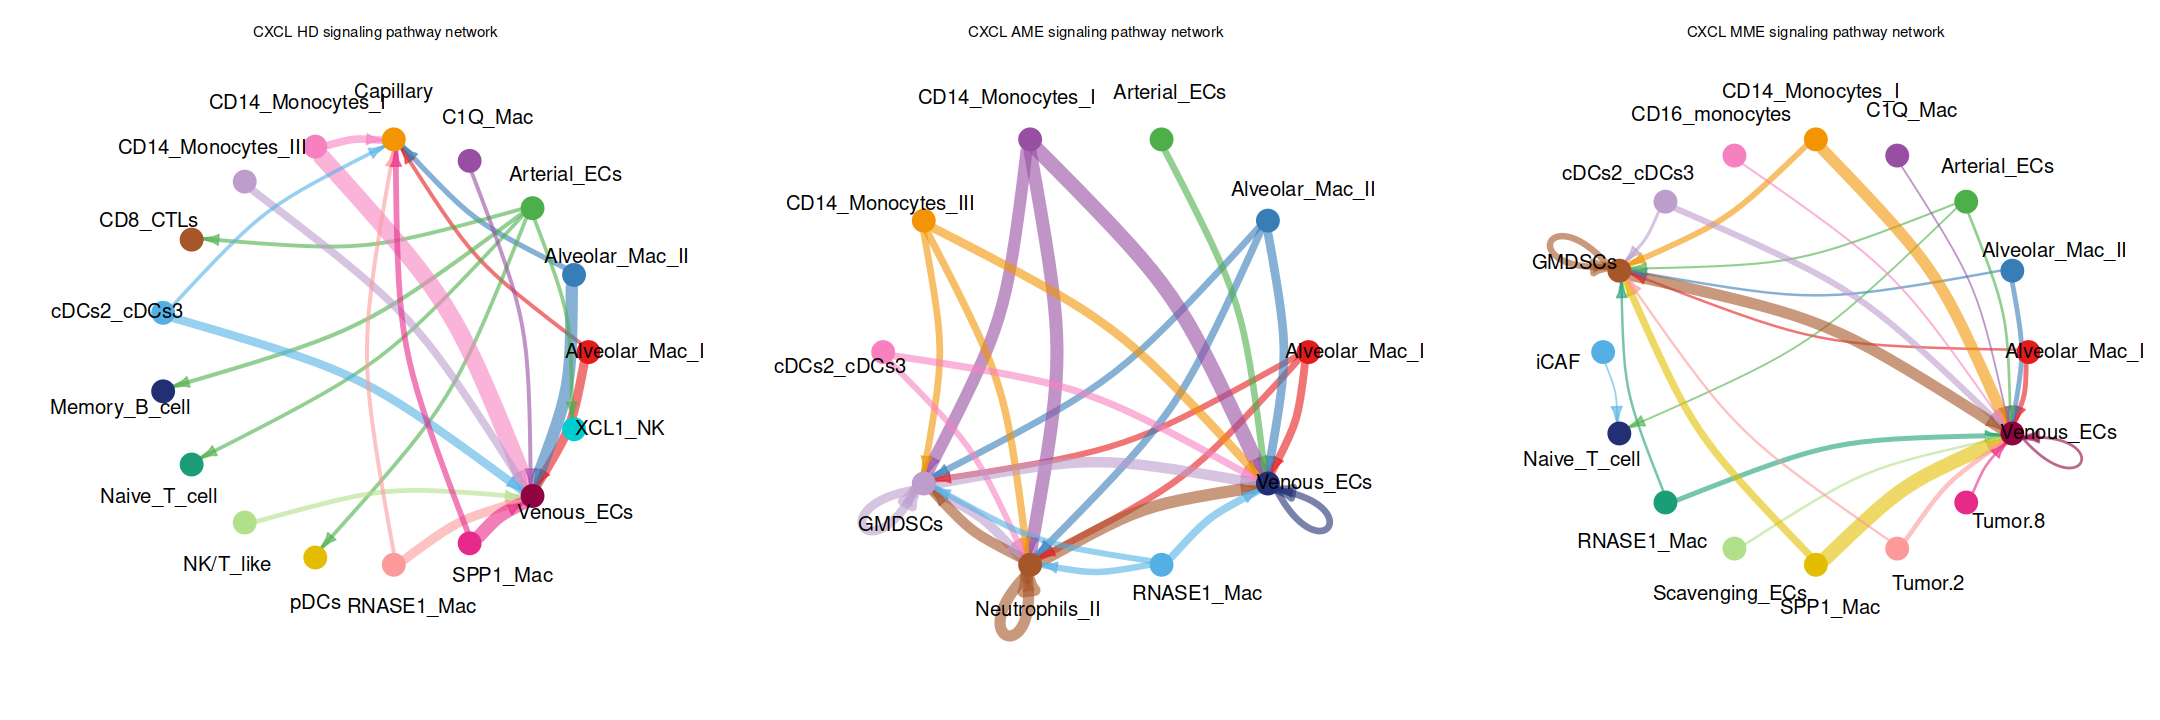

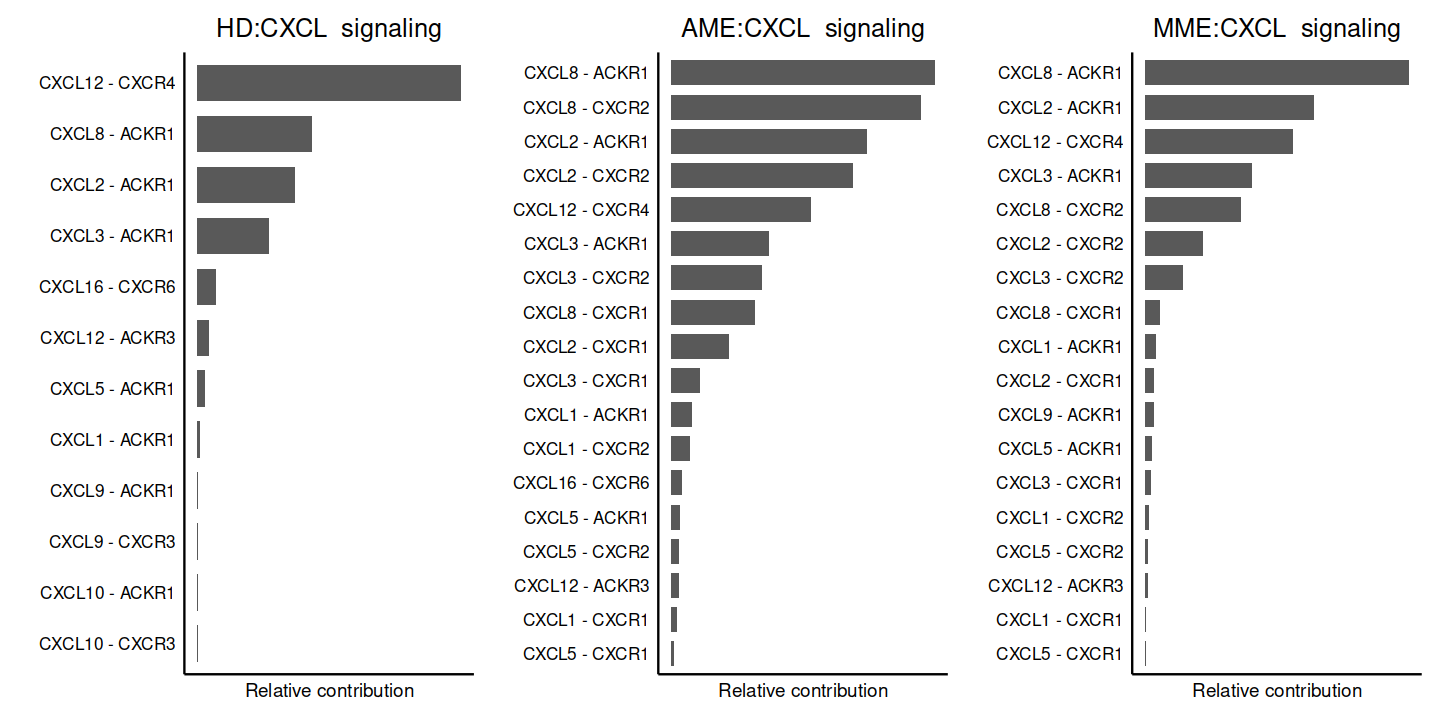

In [12]:
# Plot CXCL Signaling
options(repr.plot.height = 6, repr.plot.width = 18)
pathways.show <- c("CXCL") 
weight.max <- getMaxWeight(object.list, slot.name = c("netP"), attribute = pathways.show) # control the edge weights across different datasets
par(mfrow = c(1,3), xpd=TRUE)
for (i in 1:length(object.list)) {
  netVisual_aggregate(object.list[[i]], signaling = pathways.show,remove.isolate = T, top = 0.01, layout = "circle", edge.weight.max = weight.max[1], 
                      edge.width.max = 10,thresh = 0.05,vertex.label.cex = 1.5, signaling.name = paste(pathways.show, names(object.list)[i]))
}

options(repr.plot.height= 6, repr.plot.width = 12)
par(mfrow = c(1,3), xpd=TRUE)
pathways.show <- c("CXCL")

p1 <- netAnalysis_contribution(object.list$HME, signaling = pathways.show, font.size.title = 15,
                         title = "HME:CXCL  signaling")
p2 <- netAnalysis_contribution(object.list$CCME, signaling = pathways.show,font.size.title = 15,
                         title = "CCME:CXCL  signaling")
p3 <- netAnalysis_contribution(object.list$MME, signaling = pathways.show,font.size.title = 15,
                         title = "MME:CXCL  signaling")

p1+p2+p3

Comparing communications on a single object 




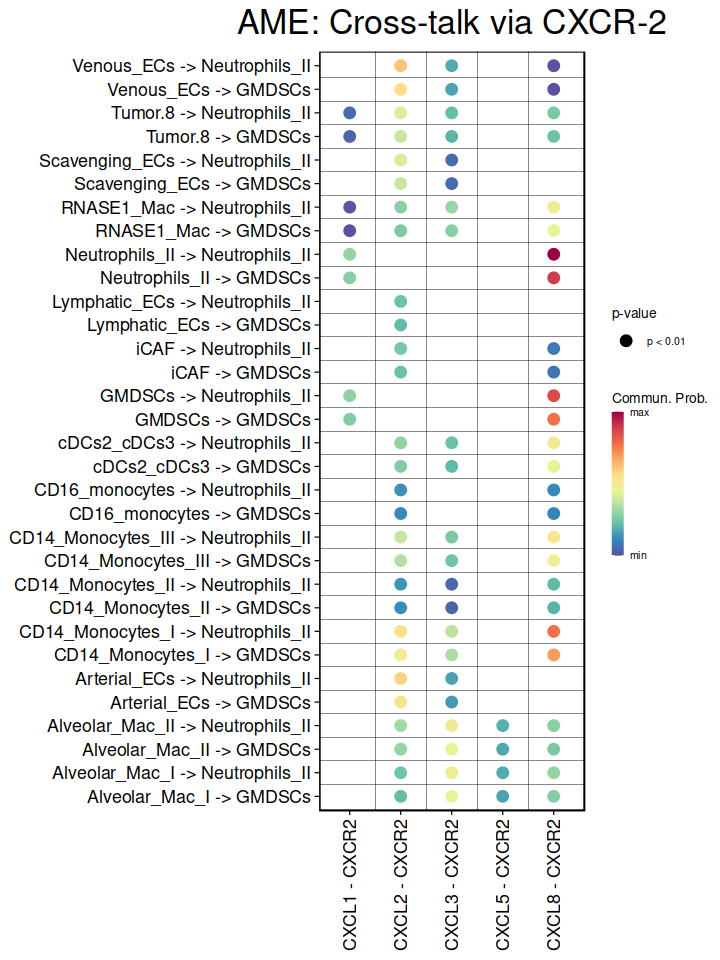

In [10]:
# Create combined list of cellchat objects 
object.list_H_A_M <- list(HME = cellchat_HME, CCME = cellchat_CCME, MME = cellchat_MME)

object.list <- object.list_H_A_M

pathways.show <- c("CXCL")
pairLR <- extractEnrichedLR(object.list$CCME, signaling = pathways.show, geneLR.return = F)
pairLR_1 <- as.data.frCCME(pairLR[11:15, ])
names(pairLR_1) <- "interaction_name"

options(repr.plot.height = 8, repr.plot.width = 6)
# show all the significant interactions (L-R pairs) associated with certain signaling pathways

netVisual_bubble(cellchat_CCME, 
                 thresh = 0.001,
                 #sources.use = 4,
                 #targets.use = c(5:11), 
                 #signaling = c("CXCL"), 
                 pairLR.use = pairLR_1,
                 remove.isolate = T,
                 font.size = 13,
                title.name = "CCME: Cross-talk via CXCR-2",
                font.size.title = 20,
                color.grid = "black",
                line.size = 0.5) + coord_flip()

## CellChat: TNF signaling

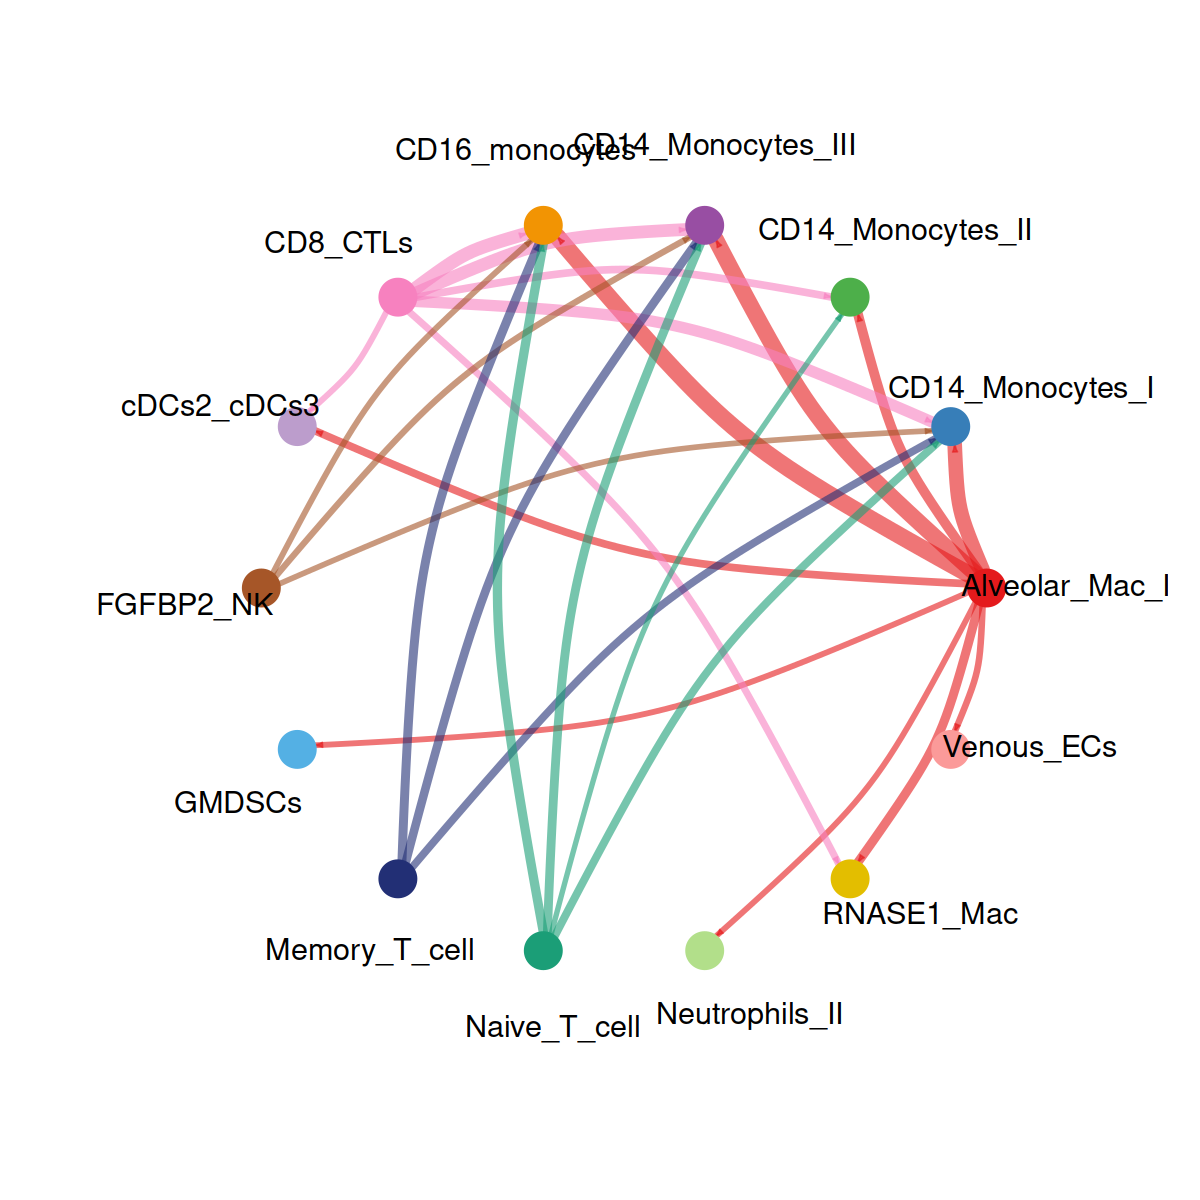

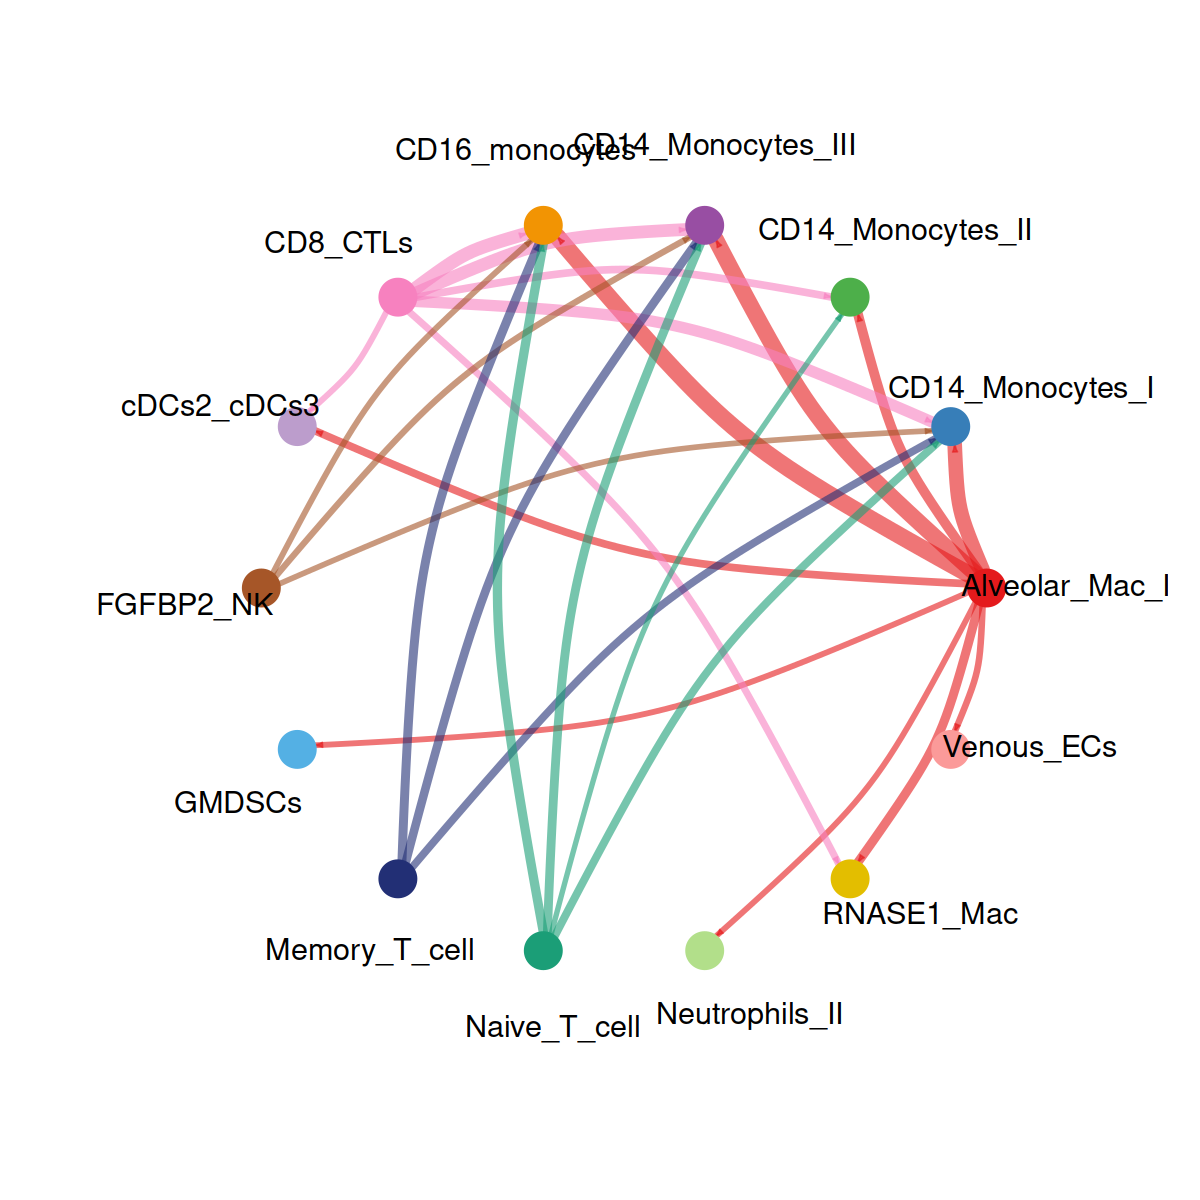

In [10]:
pathways.show <- c("TNF") 
options(repr.plot.width = 10, repr.plot.height = 10)
netVisual_aggregate(cellchat_CCME, signaling = pathways.show,remove.isolate = T, top = 0.01, layout = "circle", 
                      edge.width.max = 10,thresh = 0.05,vertex.label.cex = 1.5, signaling.name = paste(pathways.show, names(cellchat_CCME)))
options(repr.plot.width = 7, repr.plot.height = 7)

## CellChat: DC-CD8 Interactions

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


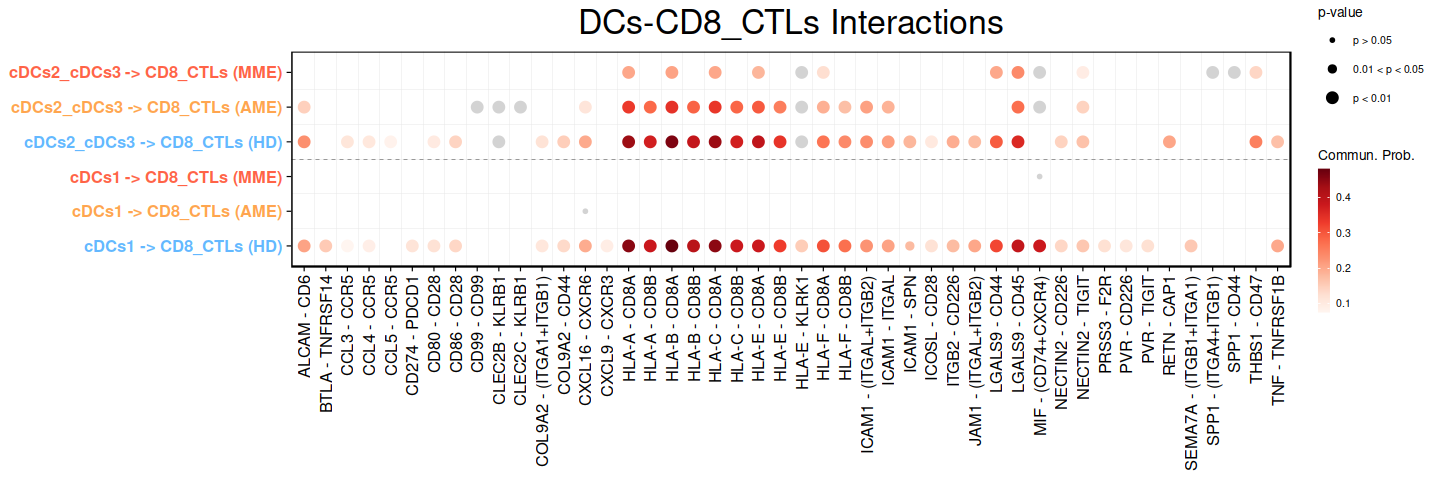

In [45]:
# create combined cellchat object
object.list_H_A_M <- list(HME = cellchat_HME, CCME = cellchat_CCME, MME = cellchat_MME)
cellchat_H_A_M <- mergeCellChat(object.list_H_A_M, add.names = names(object.list_H_A_M))


p1 <- netVisual_bubble(cellchat_H_A_M,  targets.use = c("CD8_CTLs"), sources.use = c("cDCs1", "cDCs2_cDCs3"), font.size = 12,
                 remove.isolate = F, 
                 color.text.use = F,
                 comparison = c(1,2,3), angle.x = 90,thresh = 0.05,
                 max.dataset = 1,
                 #color.heatmap = c("viridis"),
                title.name = "DCs-CD8_CTLs Interactions",
                font.size.title = 20) + coord_flip() + 
theme(axis.text.y =element_text(color= c("steelblue1","tan1", "tomato"), face = "bold"),
     axis.text.x =element_text(color= c("black"))) + 
scale_color_gradientn(colors = brewer.pal(n = 9, "Reds"), na.value = 'lightgray')

options(repr.plot.height = 4, repr.plot.width = 12)
p1 
options(repr.plot.width = 7, repr.plot.height = 7)

## CellChat: TIGIT/NECTIN signaling.................

Do heatmap based on a single object 




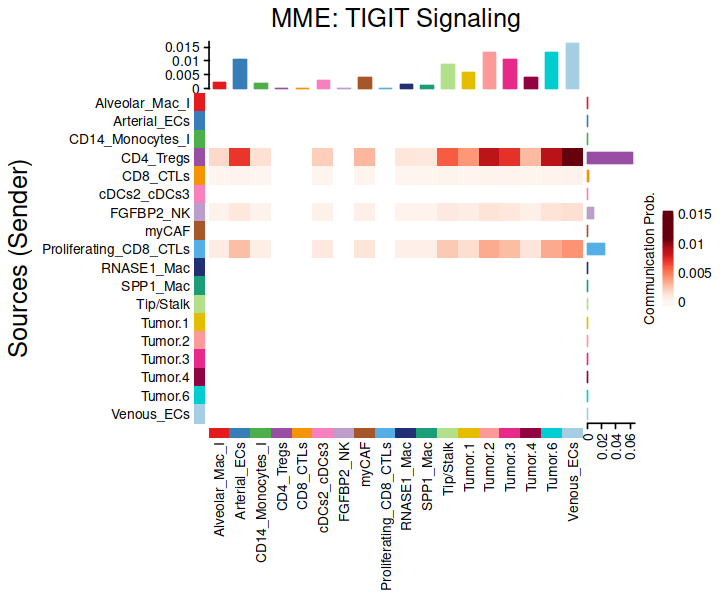

In [6]:
options(repr.plot.height =5, repr.plot.width = 6)
pathways.show <- c("TIGIT") 
netVisual_heatmap(cellchat_MME, signaling = pathways.show, color.heatmap = "Reds",measure = c("count"),
                  font.size = 8,remove.isolate = T,
                  title.name = "MME: TIGIT Signaling", font.size.title = 15)

Do heatmap based on a single object 




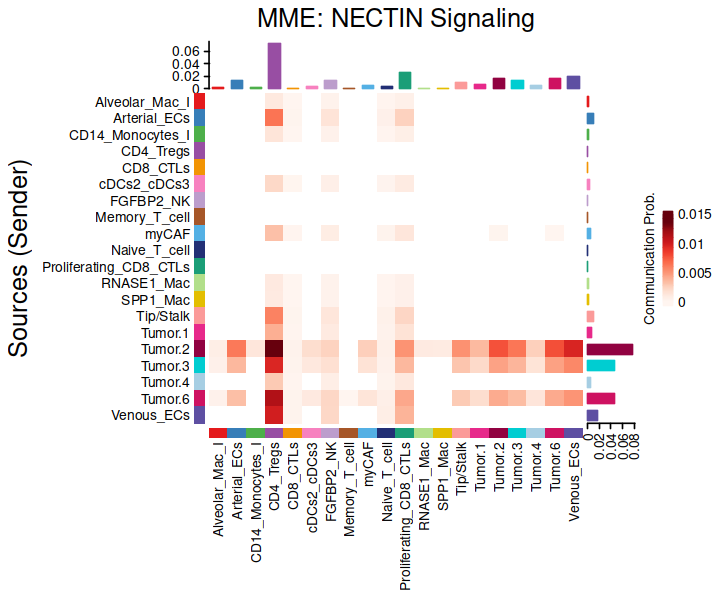

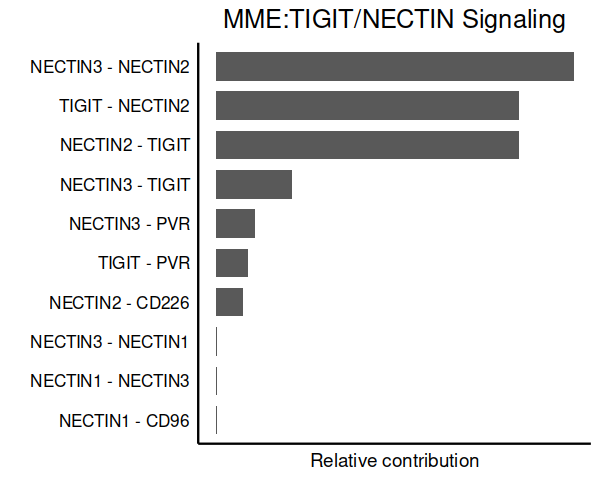

In [7]:
pathways.show <- c("NECTIN") 
netVisual_heatmap(cellchat_MME, signaling = pathways.show, color.heatmap = "Reds",measure = c("count"),
                  font.size = 8,remove.isolate = T,
                  title.name = "MME: NECTIN Signaling", font.size.title = 15)

par(mfrow = c(1,3), xpd=TRUE)
pathways.show <- c("TIGIT", "NECTIN")

p1 <- netAnalysis_contribution(cellchat_MME, signaling = pathways.show, font.size.title = 15,
                         title = "MME:TIGIT/NECTIN Signaling")

options(repr.plot.height= 4, repr.plot.width =5 )

p1

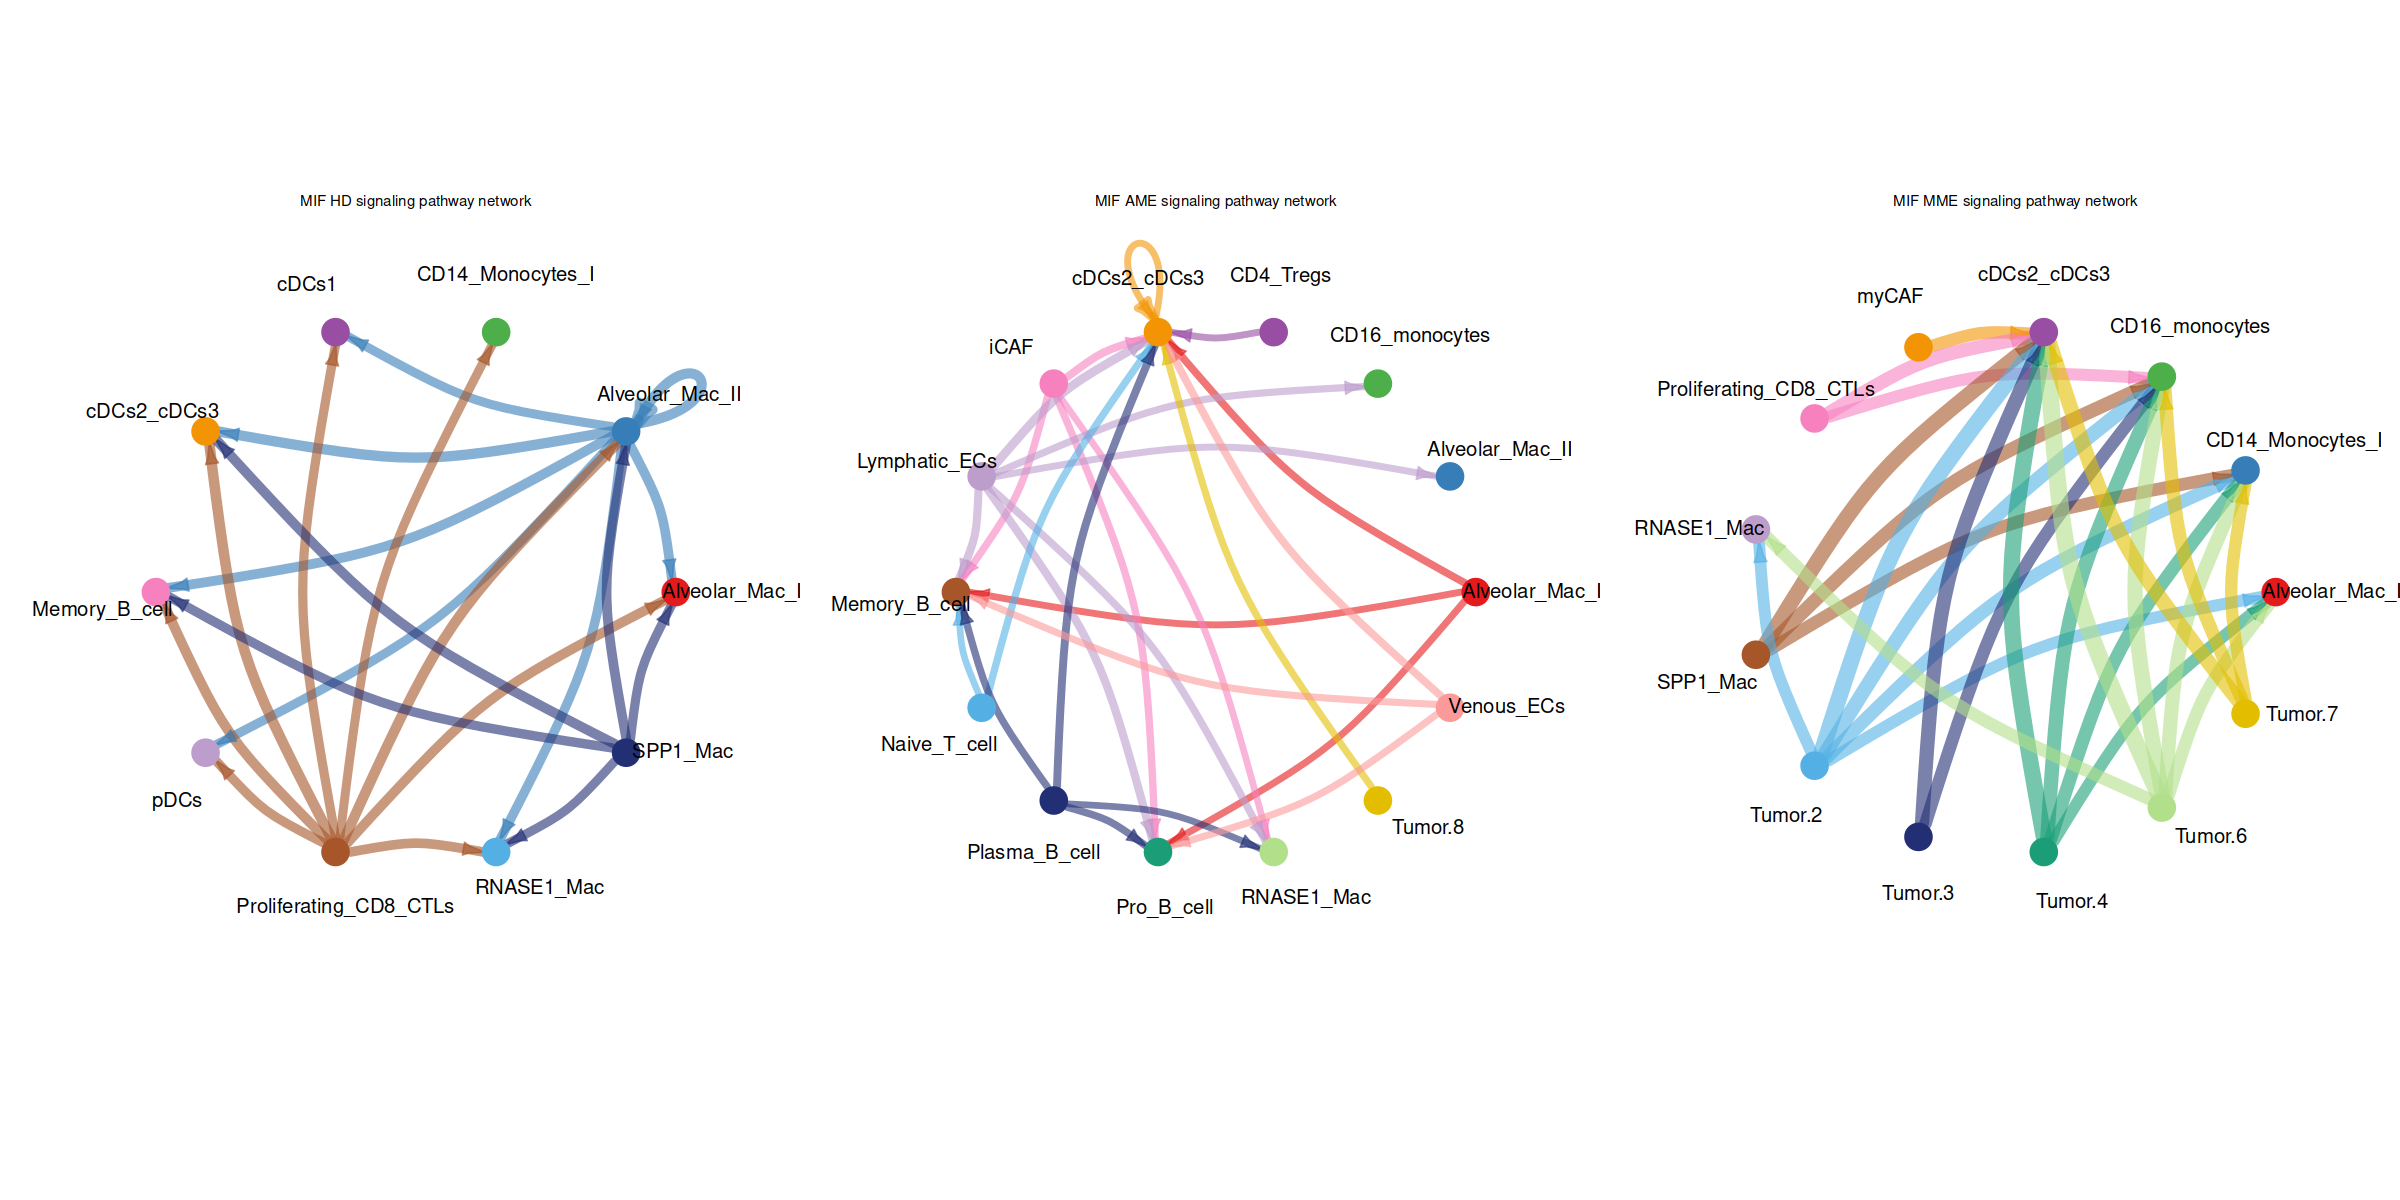

In [19]:
options(repr.plot.height = 10, repr.plot.width = 20)
pathways.show <- c("MIF") 
weight.max <- getMaxWeight(object.list, slot.name = c("netP"), attribute = pathways.show) # control the edge weights across different datasets
par(mfrow = c(1,3), xpd=TRUE)
for (i in 1:length(object.list)) {
  netVisual_aggregate(object.list[[i]], signaling = pathways.show,remove.isolate = T, top = 0.01, layout = "circle", edge.weight.max = weight.max[1], 
                      edge.width.max = 10,thresh = 0.05,vertex.label.cex = 1.5, signaling.name = paste(pathways.show, names(object.list)[i]))
}

In [4]:
# Create combined cellchat object from HME, CCME
object.list_H_A <- list(HME = cellchat_HME, CCME = cellchat_CCME)
cellchatHA <- mergeCellChat(object.list_H_A, add.names = names(object.list_H_A))

# Create combined cellchat object from HME and MME
object.list_H_M <- list(HME = cellchat_HME, MME = cellchat_MME)
cellchatHM <- mergeCellChat(object.list_H_M, add.names = names(object.list_H_M))

Merge the following slots: 'data.signaling','images','net', 'netP','meta', 'idents', 'var.features' , 'DB', and 'LR'.

Merge the following slots: 'data.signaling','images','net', 'netP','meta', 'idents', 'var.features' , 'DB', and 'LR'.



### CCME vs HME

In [52]:
# define a positive dataset, i.e., the dataset with positive fold change against the other dataset
pos.dataset = "CCME"
# define a char name used for storing the results of differential expression analysis
features.name = pos.dataset
# perform differential expression analysis
cellchatHA <- identifyOverExpressedGenes(cellchatHA, group.dataset = "datasets", 
                                         pos.dataset = pos.dataset, features.name = features.name, 
                                         only.pos = FALSE, thresh.pc = 0.1, thresh.fc = 0.3, thresh.p = 0.05)
# map the results of differential expression analysis onto the inferred cell-cell communications to easily manage/subset the ligand-receptor pairs of interest
net_HA <- netMappingDEG(cellchatHA, features.name = features.name)


Use the joint cell labels from the merged CellChat object



In [53]:
# extract the ligand-receptor pairs with upregulated signaling in CCME
net.up_HA <- subsetCommunication(cellchatHA, net = net_HA, datasets = "CCME", ligand.logFC = 0.1, receptor.logFC = 0.1) 
# extract the ligand-receptor pairs with upregulated ligands and upregulated recetptors in HME, i.e.,downregulated in CCME
net.down_HA <- subsetCommunication(cellchatHA, net = net_HA, datasets = "CCME", ligand.logFC = -0.1, receptor.logFC = -0.1)

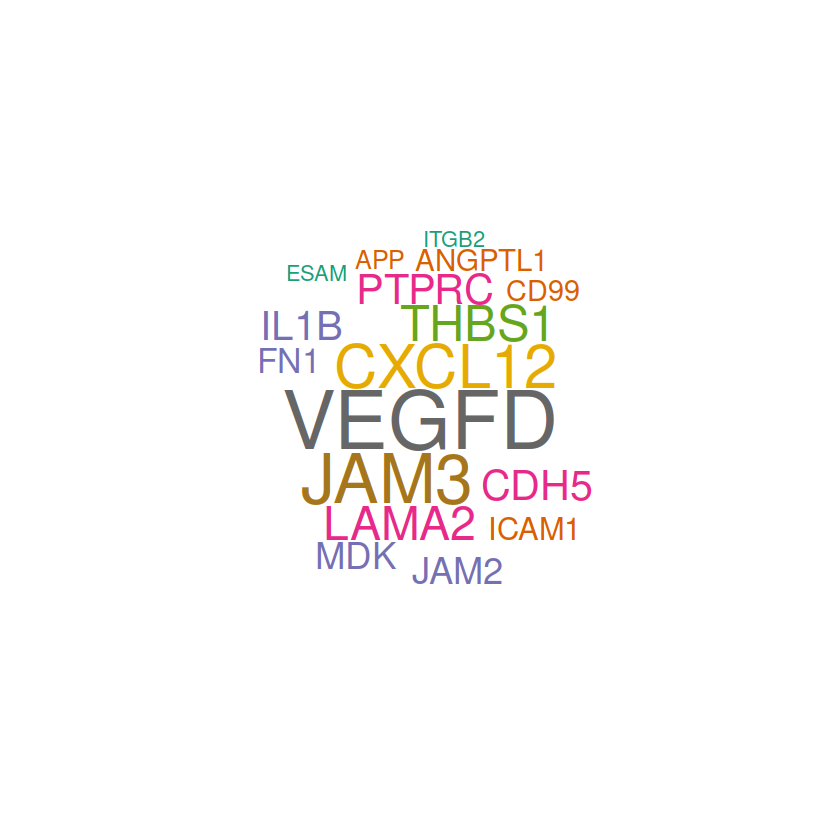

In [59]:
# visualize the enriched ligands in HME
df.down_HA <- computeEnrichmentScore(net.down_HA, species = 'human', return.data = TRUE)

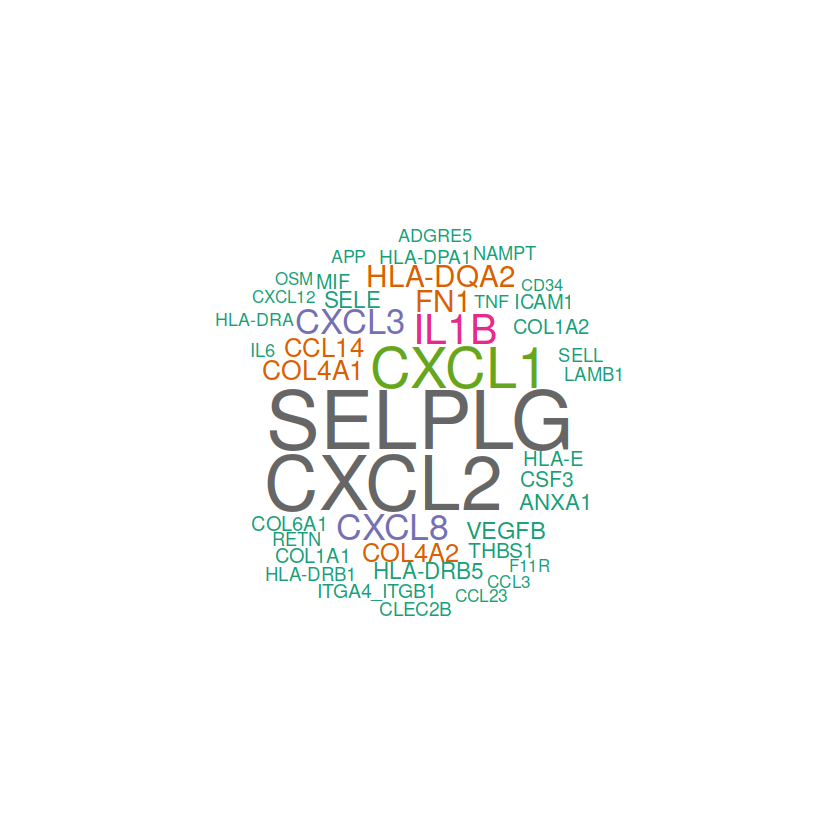

In [60]:
# visualize the enriched ligands in CCME
df.up_HA <- computeEnrichmentScore(net.up_HA, species = 'human', return.data = TRUE)

In [61]:
# save output tables
write.csv(df.up_HA, "../Etan/Tables/LR_up_in_CCMEvsHME.csv")
write.csv(df.down_HA, "../Etan/Tables/LR_down_in_CCMEvsHME.csv")

### MME vs HME

In [62]:
# define a positive dataset, i.e., the dataset with positive fold change against the other dataset
pos.dataset = "MME"
# define a char name used for storing the results of differential expression analysis
features.name = pos.dataset
# perform differential expression analysis
cellchatHM <- identifyOverExpressedGenes(cellchatHM, group.dataset = "datasets", 
                                         pos.dataset = pos.dataset, features.name = features.name, 
                                         only.pos = FALSE, thresh.pc = 0.1, thresh.fc = 0.3, thresh.p = 0.05)
# map the results of differential expression analysis onto the inferred cell-cell communications to easily manage/subset the ligand-receptor pairs of interest
net_HM <- netMappingDEG(cellchatHM, features.name = features.name)


Use the joint cell labels from the merged CellChat object



In [64]:
# extract the ligand-receptor pairs with upregulated signaling in MME
net.up_HM <- subsetCommunication(cellchatHM, net = net_HM, datasets = "MME", ligand.logFC = 0.1, receptor.logFC = 0.1) 
# extract the ligand-receptor pairs with upregulated ligands and upregulated recetptors in HME, i.e.,downregulated in MME
net.down_HM <- subsetCommunication(cellchatHM, net = net_HM, datasets = "MME", ligand.logFC = -0.1, receptor.logFC = -0.1)

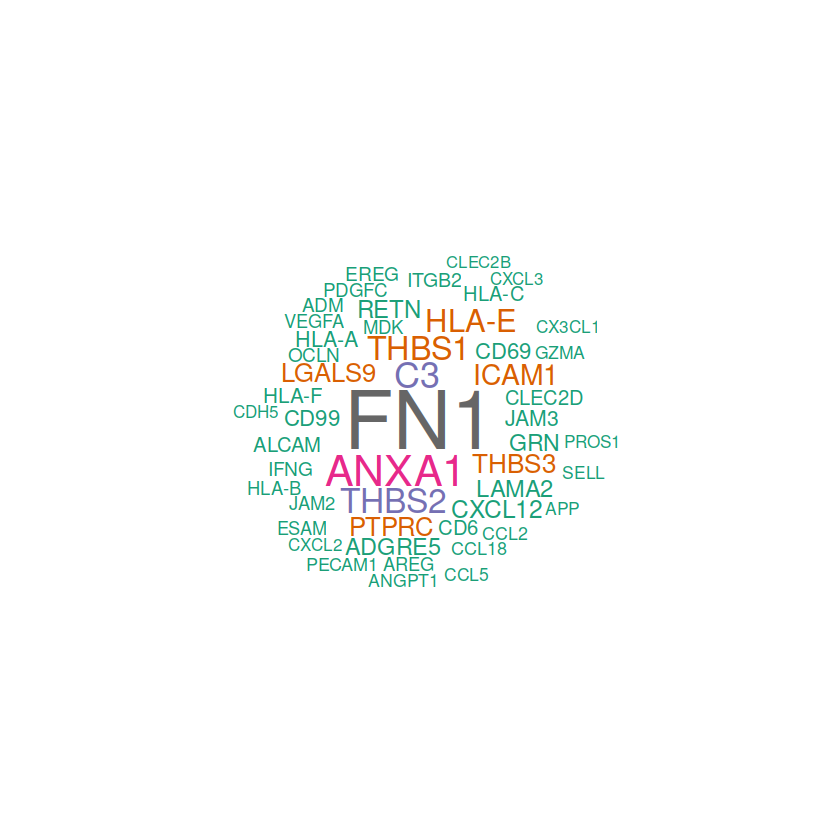

In [65]:
# visualize the enriched ligands in HME
df.down_HM <- computeEnrichmentScore(net.down_HM, species = 'human', return.data = TRUE)

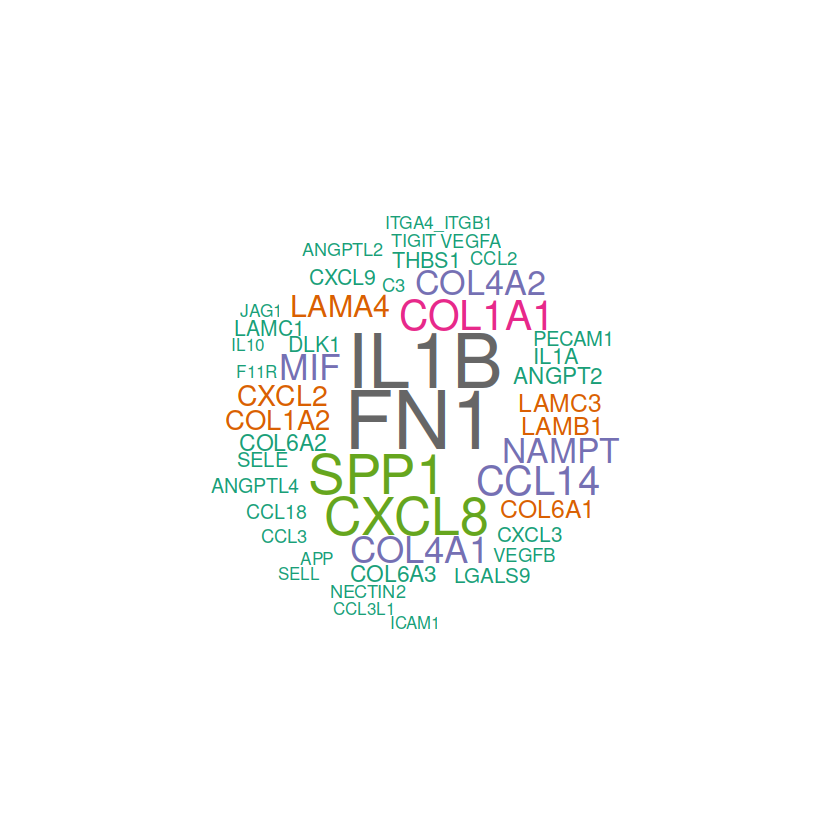

In [66]:
# visualize the enriched ligands in MME
df.up_HM <- computeEnrichmentScore(net.up_HM, species = 'human', return.data = TRUE)

In [67]:
# save output tables
write.csv(df.up_HM, "../Etan/Tables/LR_up_in_MMEvsHME.csv")
write.csv(df.down_HM, "../Etan/Tables/LR_down_in_MMEvsHME.csv")

### Find shared differential interactions in CCME and MME

In [1]:
# load output tables
df.up_HM <- read.csv("../Etan/Tables/LR_up_in_MMEvsHME.csv")
df.down_HM <- read.csv("../Etan/Tables/LR_down_in_MMEvsHME.csv")
df.up_HA <- read.csv("../Etan/Tables/LR_up_in_CCMEvsHME.csv")
df.down_HA <- read.csv("../Etan/Tables/LR_down_in_CCMEvsHME.csv")

In [5]:
# identify ligands with upregulated signaling in both CCME and MME
hm <- df.up_HM$ligand
ha <- df.up_HA$ligand
candidates <- hm[hm %in% ha]
filter(df.up_HM, ligand %in% candidates) %>% arrange(desc(total))
filter(df.up_HA, ligand %in% candidates) %>% arrange(desc(total))

X,ligand,total
<int>,<chr>,<dbl>
24,FN1,0.1792343830
28,IL1B,0.1662988775
20,CXCL8,0.0992431410
11,COL1A1,0.0679036926
6,CCL14,0.0656751449
13,COL4A1,0.0556296963
36,MIF,0.0529503822
14,COL4A2,0.0493337179
37,NAMPT,0.0478965933


X,ligand,total
<int>,<chr>,<dbl>
17,CXCL2,0.257185285
29,IL1B,0.108243497
19,CXCL8,0.084006398
18,CXCL3,0.079334749
21,FN1,0.058397545
11,COL4A1,0.044283911
4,CCL14,0.041088664
12,COL4A2,0.039686164
42,VEGFB,0.031323473


#### Figure out which cell types are represented in each group

In [44]:
HME_idents <- unique(cellchat_HME@idents)
CCME_idents <- unique(cellchat_CCME@idents)
mme_idents <- unique(cellchat_MME@idents)
HME_idents
CCME_idents
mme_idents


[1] aCAP_type_II           aCAP_type_I            Scavenging_ECs        
 [4] Venous_ECs             Capillary              VSMC                  
 [7] Arterial_ECs           Lymphatic_ECs          Pericytes             
[10] Tip/Stalk              LSECs                  Fibroblast_I          
[13] iCAF                   Hepatic_Stellates      myCAF                 
[16] Mast_cells             Alveolar_Mac_I         cDCs2_cDCs3           
[19] CD14_Monocytes_II      RNASE1_Mac             CD14_Monocytes_I      
[22] NK/T_like              CD16_monocytes         pDCs                  
[25] CD14_Monocytes_III     Alveolar_Mac_II        SPP1_Mac              
[28] C1Q_Mac                cDCs1                  GMDSCs                
[31] Kupffer_cells          Neutrophils_II         Neutrophils_I         
[34] Naive_T_cell           FGFBP2_NK              CD8_CTLs              
[37] Plasma_B_cell          Memory_B_cell          Memory_T_cell         
[40] XCL1_NK                Proliferating_CD8_CTLs HAVCAR2_CD4_T_cell    
[43] CD4_Tregs              Pro_B_cell            
44 Levels: aCAP_type_I aCAP_type_II Alveolar_Mac_I ... XCL1_NK

[1] Arterial_ECs           Scavenging_ECs         Lymphatic_ECs         
 [4] Venous_ECs             Capillary              aCAP_type_I           
 [7] aCAP_type_II           Tip/Stalk              VSMC                  
[10] LSECs                  Pericytes              iCAF                  
[13] myCAF                  Hepatic_Stellates      Fibroblast_I          
[16] Alveolar_Mac_I         CD14_Monocytes_I       CD16_monocytes        
[19] CD14_Monocytes_II      Alveolar_Mac_II        cDCs1                 
[22] cDCs2_cDCs3            RNASE1_Mac             CD14_Monocytes_III    
[25] GMDSCs                 C1Q_Mac                SPP1_Mac              
[28] NK/T_like              Neutrophils_II         Neutrophils_I         
[31] Mast_cells             pDCs                   Kupffer_cells         
[34] FGFBP2_NK              Proliferating_CD8_CTLs CD8_CTLs              
[37] Naive_T_cell           CD4_Tregs              XCL1_NK               
[40] HAVCAR2_CD4_T_cell     Memory_B_cell          Pro_B_cell            
[43] Plasma_B_cell          Memory_T_cell          Tumor.5               
[46] Tumor.8                Tumor.4                Tumor.7               
[49] Tumor.1                Tumor.2               
50 Levels: aCAP_type_I aCAP_type_II Alveolar_Mac_I ... XCL1_NK

[1] Tip/Stalk              Scavenging_ECs         aCAP_type_I           
 [4] Venous_ECs             Arterial_ECs           Pericytes             
 [7] aCAP_type_II           VSMC                   Capillary             
[10] Lymphatic_ECs          LSECs                  iCAF                  
[13] myCAF                  Hepatic_Stellates      Fibroblast_I          
[16] C1Q_Mac                RNASE1_Mac             CD14_Monocytes_II     
[19] SPP1_Mac               cDCs2_cDCs3            cDCs1                 
[22] CD16_monocytes         CD14_Monocytes_I       Kupffer_cells         
[25] NK/T_like              GMDSCs                 Alveolar_Mac_II       
[28] CD14_Monocytes_III     Alveolar_Mac_I         Mast_cells            
[31] Neutrophils_II         Naive_T_cell           FGFBP2_NK             
[34] Proliferating_CD8_CTLs CD8_CTLs               HAVCAR2_CD4_T_cell    
[37] Memory_T_cell          CD4_Tregs              Pro_B_cell            
[40] Plasma_B_cell          XCL1_NK                Memory_B_cell         
[43] Tumor.7                Tumor.4                Tumor.5               
[46] Tumor.6                Tumor.8                Tumor.3               
[49] Tumor.1                Tumor.2               
50 Levels: aCAP_type_I aCAP_type_II Alveolar_Mac_I ... XCL1_NK

In [47]:
HME_idents[!HME_idents %in% mme_idents]
HME_idents[!HME_idents %in% CCME_idents]
CCME_idents[!CCME_idents %in% mme_idents]
CCME_idents[!CCME_idents %in% HME_idents]
mme_idents[!mme_idents %in% CCME_idents]
mme_idents[!mme_idents %in% HME_idents]

[1] pDCs          Neutrophils_I
44 Levels: aCAP_type_I aCAP_type_II Alveolar_Mac_I ... XCL1_NK

factor(0)
44 Levels: aCAP_type_I aCAP_type_II Alveolar_Mac_I ... XCL1_NK

[1] Neutrophils_I pDCs         
50 Levels: aCAP_type_I aCAP_type_II Alveolar_Mac_I ... XCL1_NK

[1] Tumor.5 Tumor.8 Tumor.4 Tumor.7 Tumor.1 Tumor.2
50 Levels: aCAP_type_I aCAP_type_II Alveolar_Mac_I ... XCL1_NK

[1] Tumor.6 Tumor.3
50 Levels: aCAP_type_I aCAP_type_II Alveolar_Mac_I ... XCL1_NK

[1] Tumor.7 Tumor.4 Tumor.5 Tumor.6 Tumor.8 Tumor.3 Tumor.1 Tumor.2
50 Levels: aCAP_type_I aCAP_type_II Alveolar_Mac_I ... XCL1_NK

### Identify differential signaling networks based on functional similarity

In [49]:
group.new = levels(cellchat_CCME@idents)
#cellchat_CCME <- liftCellChat(cellchat_CCME, group.new)
cellchat_HME <- liftCellChat(cellchat_HME, group.new)

The CellChat object will be lifted up using the cell labels aCAP_type_I, aCAP_type_II, Alveolar_Mac_I, Alveolar_Mac_II, Arterial_ECs, C1Q_Mac, Capillary, CD14_Monocytes_I, CD14_Monocytes_II, CD14_Monocytes_III, CD16_monocytes, CD4_Tregs, CD8_CTLs, cDCs1, cDCs2_cDCs3, FGFBP2_NK, Fibroblast_I, GMDSCs, HAVCAR2_CD4_T_cell, Hepatic_Stellates, iCAF, Kupffer_cells, LSECs, Lymphatic_ECs, Mast_cells, Memory_B_cell, Memory_T_cell, myCAF, Naive_T_cell, Neutrophils_I, Neutrophils_II, NK/T_like, pDCs, Pericytes, Plasma_B_cell, Pro_B_cell, Proliferating_CD8_CTLs, RNASE1_Mac, Scavenging_ECs, SPP1_Mac, Tip/Stalk, Tumor.1, Tumor.2, Tumor.4, Tumor.5, Tumor.7, Tumor.8, Venous_ECs, VSMC, XCL1_NK



Update slots object@net, object@netP, object@idents in a single dataset... 


In [42]:
# Comparing pathways across datasets. However, can only compare using structural similarity not functional
# (between similar signaling network structure, not functionally similar ligands and receptors)

# To do functional comparison, would need to have sCCME cell types in both objects

#> Compute signaling network similarity for datasets 1 2
cellchatHA <- computeNetSimilarityPairwise(cellchatHA, type = "structural")
#> Manifold learning of the signaling networks for datasets 1 2
cellchatHA <- netEmbedding(cellchatHA, type = "structural")
#> Classification learning of the signaling networks for datasets 1 2
cellchatHA <- netClustering(cellchatHA, type = "structural")
#> Compute the distance of signaling networks between datasets 1 2
rankSimilarity(cellchatHA, type = "structural")
rankNet(cellchatHA, mode = "comparison", stacked = T, do.stat = TRUE)

In [23]:
?computeEnrichmentScore

computeEnrichmentScore {CellChat},R Documentation
df,a dataframe
measure,"compute the enrichment score in terms of ""ligand"", ""signaling"",or ""LR-pair"""
species,a vector giving the groups of different datasets to define colors of the bar plot. Default: only one group and a single color
color.use,defining the color for each group of datasets
color.name,the color names in RColorBrewer::brewer.pal
n.color,the number of colors
scale,A vector of length 2 indicating the range of the size of the words.
min.freq,words with frequency below min.freq will not be plotted
max.words,Maximum number of words to be plotted. least frequent terms dropped
random.order,"plot words in random order. If false, they will be plotted in decreasing frequency"
